# Weather Data Analysis with a public API

In [1]:
import grequests as asynhttp
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib

### Data Collection and Cleaning

In [2]:
capitales = {
    "Africa": ["El Cairo", "Abuya", "Nairobi", "Addis Abeba", "Pretoria"],
    "America": ["Washington D. C.", "Ottawa", "Ciudad de México", "Brasilia", "Buenos Aires",],
    "Asia": ["Pekín", "Tokio", "Nueva Delhi", "Seúl", "Riad"],
    "Europa": ["Madrid", "París", "Berlín", "Roma", "Londres"],
    "Oceania": ["Canberra", "Wellington", "Port Moresby", "Suva", "Apia"],
}
key="030c86ad50fe0b9ad9817deeb4fc2825"

In [3]:
localizaciones={
    "continente": [],
    "name": [],
    "lat": [],
    "lon": []
}

rs=[]
for continente in capitales:
    for ciudad in capitales[continente]:
        url=f"http://api.openweathermap.org/geo/1.0/direct?q={ciudad}&appid={key}"
        rs.append(asynhttp.get(url))
        localizaciones["continente"].append(continente)
        
futures = asynhttp.map(rs)
for futuro in futures:
    response=futuro.json()    
    localizaciones["name"].append(response[0]["name"])
    localizaciones["lat"].append(response[0]["lat"])
    localizaciones["lon"].append(response[0]["lon"])

In [4]:
df_localizaciones=pd.DataFrame(localizaciones).set_index("name")
df_localizaciones

,continente,lat,lon
name,,,
Cairo,Africa,30.044388,31.235726
Abuja,Africa,9.064331,7.489297
Nairobi,Africa,-1.303264,36.826384
Addis Ababa,Africa,9.010793,38.761252
Pretoria,Africa,-25.745928,28.187910
Washington,America,38.895037,-77.036543
Ottawa,America,45.420878,-75.690111
Mexico City,America,19.432630,-99.133178
Brasília,America,-15.793404,-47.882317


In [5]:
rs=[]
for entrada in df_localizaciones.values:
    url=f"https://api.openweathermap.org/data/2.5/weather?lat={entrada[1]}&lon={entrada[2]}&appid={key}&units=metric&lang=sp"
    rs.append(asynhttp.get(url))

tiempo=[]
futures = asynhttp.map(rs)
for futuro in futures:
    tiempo.append(json.loads(futuro.text))

In [6]:
for ciudad in tiempo:
    for i, e in enumerate(ciudad["weather"]):
        del ciudad["weather"][i]["id"]
        del ciudad["weather"][i]["icon"]

In [7]:
df_tiempo = pd.json_normalize(tiempo, "weather", [["main", "temp"], ["main", "feels_like"],
    ["main", "temp_min"],["main", "temp_max"],["main", "pressure"],["main", "humidity"],
    ["main", "sea_level"],["main", "grnd_level"], "visibility", ["wind", "speed"], ["wind", "deg"], 
    ["wind", "gust"], ["rain", "1h"], ["snow", "1h"], ["clouds", "all"], "dt"], sep="-", errors="ignore")

In [8]:
df_tiempo = df_localizaciones.reset_index().join(df_tiempo)

In [9]:
df_tiempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             25 non-null     object 
 1   continente       25 non-null     object 
 2   lat              25 non-null     float64
 3   lon              25 non-null     float64
 4   main             25 non-null     object 
 5   description      25 non-null     object 
 6   main-temp        25 non-null     object 
 7   main-feels_like  25 non-null     object 
 8   main-temp_min    25 non-null     object 
 9   main-temp_max    25 non-null     object 
 10  main-pressure    25 non-null     object 
 11  main-humidity    25 non-null     object 
 12  main-sea_level   25 non-null     object 
 13  main-grnd_level  25 non-null     object 
 14  visibility       25 non-null     object 
 15  wind-speed       25 non-null     object 
 16  wind-deg         25 non-null     object 
 17  wind-gust        8

In [10]:
df_tiempo = df_tiempo.astype({"main-temp": "float", "main-feels_like": "float", "main-temp_min": "float", 
                              "main-temp_max": "float", "main-pressure": "int", "main-humidity": "int",
                              "main-sea_level": "int", "main-grnd_level": "int", "visibility": "int", 
                              "wind-speed": "float", "wind-deg": "int", "wind-gust": "float", 
                              "rain-1h": "float", "snow-1h": "float", "clouds-all": "int"})
df_tiempo["dt"] = pd.to_datetime(df_tiempo["dt"], unit="s", utc=True).dt.tz_convert("Europe/Madrid")

In [11]:
df_tiempo.fillna(0, inplace=True)

In [12]:
df_tiempo.sample(5)

,name,continente,lat,lon,main,description,main-temp,main-feels_like,main-temp_min,main-temp_max,...,main-sea_level,main-grnd_level,visibility,wind-speed,wind-deg,wind-gust,rain-1h,snow-1h,clouds-all,dt
21,Wellington,Oceania,-41.288795,174.777211,Clouds,muy nuboso,11.90,11.57,11.01,12.95,...,1000,988,10000,13.38,180,0.00,0.0,0.0,75,2025-12-03 09:50:45+01:00
0,Cairo,Africa,30.044388,31.235726,Clear,cielo claro,21.33,20.98,20.70,21.33,...,1019,1012,10000,5.14,30,0.00,0.0,0.0,0,2025-12-03 09:46:18+01:00
17,Berlin,Europa,52.517037,13.388860,Mist,niebla,2.12,0.27,1.01,3.30,...,1015,1009,4700,1.79,114,4.02,0.0,0.0,100,2025-12-03 09:39:52+01:00
18,Rome,Europa,41.893320,12.482932,Fog,bruma,7.93,6.32,6.89,9.86,...,1014,1006,600,2.57,30,0.00,0.0,0.0,100,2025-12-03 09:42:17+01:00
9,Buenos Aires,America,-34.607568,-58.437089,Clear,cielo claro,18.41,18.60,16.83,19.88,...,1013,1011,10000,1.79,318,2.24,0.0,0.0,0,2025-12-03 09:40:00+01:00


In [13]:
df_tiempo.to_csv("tiempo_global.csv")

### Data Analysis
- Which cities are the hottest and coldest right now?
- Is there a relationship between temperature and humidity?
- Which continent seems to have the windiest cities?
- What’s the most common weather description (e.g., clear, cloudy, rainy)?

In [14]:
df_tiempo.loc[df_tiempo.loc[:,"main-temp"].idxmax(), ["name", "main-temp"]]

name         Port Moresby
main-temp           28.53
Name: 22, dtype: object

In [15]:
df_tiempo.loc[df_tiempo.loc[:,"main-temp"].idxmin(), ["name", "main-temp"]]

name         Ottawa
main-temp     -9.79
Name: 6, dtype: object

In [16]:
df_tiempo.loc[:,["lat", "lon", "main-temp", "main-feels_like", "main-humidity", "main-sea_level", "wind-speed", "wind-gust"]].corr().style.background_gradient(cmap="RdBu", vmin=-1, vmax=1)

,lat,lon,main-temp,main-feels_like,main-humidity,main-sea_level,wind-speed,wind-gust
lat,1.000000,-0.181239,-0.658457,-0.666470,0.003801,0.343707,-0.205621,0.076622
lon,-0.181239,1.000000,0.137141,0.141730,-0.181135,-0.102202,0.388320,-0.060337
main-temp,-0.658457,0.137141,1.000000,0.989987,-0.259614,-0.311314,-0.000514,-0.140090
main-feels_like,-0.666470,0.141730,0.989987,1.000000,-0.183712,-0.361429,0.006705,-0.135341
main-humidity,0.003801,-0.181135,-0.259614,-0.183712,1.000000,-0.540857,0.080158,-0.294920
main-sea_level,0.343707,-0.102202,-0.311314,-0.361429,-0.540857,1.000000,-0.377330,0.358213
wind-speed,-0.205621,0.388320,-0.000514,0.006705,0.080158,-0.377330,1.000000,-0.397668
wind-gust,0.076622,-0.060337,-0.140090,-0.135341,-0.294920,0.358213,-0.397668,1.000000


In [17]:
# hacer estos dos una tabla gerarquica
df_tiempo.groupby("continente")["wind-gust"].max().sort_values(ascending=False)

continente
Asia       4.17
Europa     4.02
America    2.24
Oceania    2.24
Africa     1.61
Name: wind-gust, dtype: float64

In [18]:
df_tiempo.groupby("continente")["wind-speed"].max().sort_values(ascending=False)

continente
Oceania    13.38
Africa      6.17
Asia        5.14
America     4.63
Europa      2.57
Name: wind-speed, dtype: float64

In [19]:
df_tiempo.value_counts("main")

main
Clear     14
Clouds     7
Fog        1
Haze       1
Mist       1
Rain       1
Name: count, dtype: int64

### Visualization

<Axes: xlabel='Humedad(%)', ylabel='Latitud'>

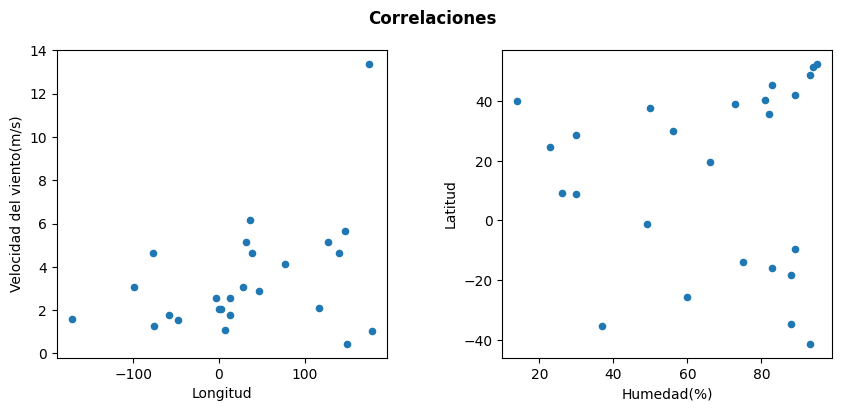

In [20]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
fig.suptitle("Correlaciones", weight="bold")
plt.subplots_adjust(wspace=0.35)
df_tiempo.loc[:,["wind-speed","lon"]].plot.scatter(ax=axs[0], x="lon", y="wind-speed", xlabel="Longitud", ylabel="Velocidad del viento(m/s)")
df_tiempo.loc[:,["main-humidity","lat"]].plot.scatter(ax=axs[1], x="main-humidity", y="lat", xlabel="Humedad(%)", ylabel="Latitud")

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(10,4), constrained_layout=True)
fig.suptitle("Temperaturas mundiales.", weight="bold")

s_temp=df_tiempo.set_index("name").loc[:,"main-temp"].sort_values()
norm = matplotlib.colors.Normalize(vmin=s_temp.min(), vmax=s_temp.max())
colors = plt.get_cmap("coolwarm")(norm(s_temp.values))
s_temp.plot.barh(ax=axs[0], figsize=(12, 5), color=colors, xlabel="Cº", ylabel="")

s_temp=df_tiempo.groupby("continente")["main-temp"].mean().sort_values()
norm = matplotlib.colors.Normalize(vmin=s_temp.min(), vmax=s_temp.max())
colors = plt.get_cmap("coolwarm")(norm(s_temp.values))
s_temp.plot.barh(ax=axs[1], color=colors, xlabel="Cº", ylabel="")

<Axes: xlabel='Cº'>

### Summary